# Importing the necessary libraries

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

# Cleaning the data

The following change of countrynames is essential for working with the geopandas library

In [3]:
df_wine1 = pd.read_csv('/Users/samuelbohn/Library/Mobile Documents/com~apple~CloudDocs/WineNot_Techlabs/TechLabsDUS_WineNot/data/raw/winemag-data-130k-v2.csv', index_col=0)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_merged = world.merge(df_wine1, how='left', left_on='name', right_on='country')
unrecognized_countries = df_wine1[~df_wine1['country'].isin(world_merged['country'])]['country'].tolist()

L = [] 
for x in unrecognized_countries:
    if x in L:
        pass
    else:
        L.append(x)
print(L)

['US', 'Czech Republic', 'England', 'Bosnia and Herzegovina', 'Macedonia']


/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_31029/100696653.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Those given countries don´t match with the library, so we have to change the names

In [4]:
replacements = {
    'US': 'United States of America',
    'Czech Republic': 'Czechia',
    'England': 'United Kingdom',
    'Bosnia and Herzegovina': 'Bosnia and Herzegovina',
    'Macedonia': 'North Macedonia'
}
df_wine1['country'] = df_wine1['country'].replace(replacements)

# Ausgabe des aktualisierten DataFrames
df_wine1

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,United States of America,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,United States of America,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,United States of America,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,United States of America,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


Now we can start with an overview of the dataset

overview (df_wine1.describe())

In [5]:
df_wine1.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


dilaras notebook:
counts of country insert in our data (katja)
frequency of the countries --> cutting out the the countries with not enough data

average of most expensive and cheapest wines per country

Samy: slope price/point for the world and for europe 

--> auf jedes land den durchschnittspreis schreiben

lowest slope doesnt mean that the price is cheap (like in switzerland)

--> "In der schweiz bekommt man für weniger geld einen qualitativ besseren wein als in deutschland. Jedoch kostet in der Schweiz im Allgemeinen der Wein mehr"
another color code

# Countryoverview

/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_31029/2177812151.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


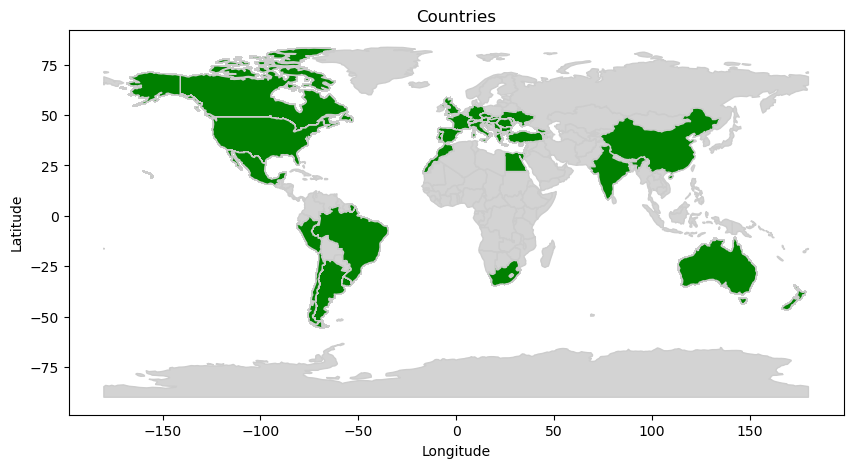

In [11]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_merged = world.merge(df_wine1, how='left', left_on='name', right_on='country')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world_merged.plot(ax=ax, color='lightgrey', edgecolor='0.8')
world_merged[world_merged['country'].notnull()].plot(ax=ax, color='green', edgecolor='0.8')
ax.set_title('Countries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

One can observe that many American and European countries are present in the dataset, along with occasional African countries, as well as China, India, and Australia.

/var/folders/d0/ypf_6_yx65s8wv8rbpl0q1zh0000gn/T/ipykernel_31029/4264965777.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


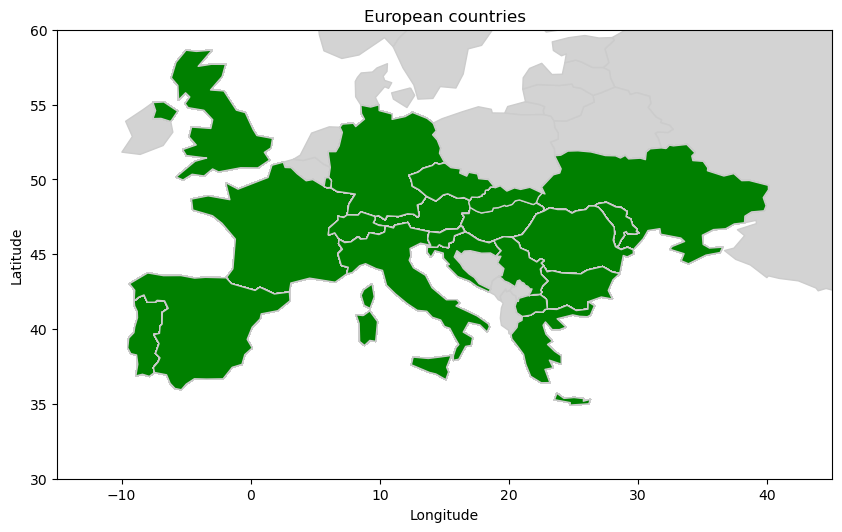

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
world_merged = europe.merge(df_wine1, how='left', left_on='name', right_on='country')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
world_merged.plot(ax=ax, color='lightgrey', edgecolor='0.8')
world_merged[world_merged['country'].notnull()].plot(ax=ax, color='green', edgecolor='0.8')

ax.set_title('European countries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

lat_min, lat_max = 30, 60
lon_min, lon_max = -15, 45

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

plt.show()

There is an huge amount of european countries in the dataset included!